In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import json

# ML libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [21]:
import os

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

print("✅ Created output directories")

✅ Created output directories


In [ ]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [6]:

#  load dataset
df = pd.read_csv('data/token_datasets.csv')

print(f"📊 Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\n🎯 Target distribution:")
print(df['label_status'].value_counts())
print(f"\nWin rate: {(df['label_status'] == 'win').mean() * 100:.2f}%")


📊 Dataset loaded: 57 rows × 30 columns

🎯 Target distribution:
label_status
loss    29
win     28
Name: count, dtype: int64

Win rate: 49.12%


In [7]:

# Feature definitions

MARKET_FEATURES = [
    'price_usd',
    'fdv_usd', 
    'liquidity_usd',
    'volume_h24_usd',
    'price_change_h24_pct',
]

SECURITY_FEATURES = [
    'creator_balance_pct',
    'top_10_holders_pct',
    'total_lp_locked_usd',
    'has_mint_authority',
    'has_freeze_authority',
    'is_lp_locked_95_plus',
]

TIME_FEATURES = [
    'time_of_day_utc',
    'day_of_week_utc',
    'is_weekend_utc',
    'is_public_holiday_any',
]

SIGNAL_FEATURES = [
    'signal_source',  # discovery or alpha
    'grade',  # CRITICAL, HIGH, MEDIUM, LOW
]

TOKEN_AGE_FEATURES = [
    'token_age_at_signal_seconds',
]

# Combine all features
FEATURE_COLS = (
    MARKET_FEATURES + 
    SECURITY_FEATURES + 
    TIME_FEATURES + 
    SIGNAL_FEATURES + 
    TOKEN_AGE_FEATURES
)

print(f"✅ Using {len(FEATURE_COLS)} features from dataset:")
print("\nFeatures:")
for f in FEATURE_COLS:
    print(f"  - {f}")

✅ Using 18 features from dataset:

Features:
  - price_usd
  - fdv_usd
  - liquidity_usd
  - volume_h24_usd
  - price_change_h24_pct
  - creator_balance_pct
  - top_10_holders_pct
  - total_lp_locked_usd
  - has_mint_authority
  - has_freeze_authority
  - is_lp_locked_95_plus
  - time_of_day_utc
  - day_of_week_utc
  - is_weekend_utc
  - is_public_holiday_any
  - signal_source
  - grade
  - token_age_at_signal_seconds


In [10]:

# Data Preprocessing

df_clean = df.copy()

# Handle missing values
print("🔍 Checking for missing values...")
df_clean[FEATURE_COLS].isnull().sum()

🔍 Checking for missing values...


price_usd                      0
fdv_usd                        0
liquidity_usd                  0
volume_h24_usd                 0
price_change_h24_pct           0
creator_balance_pct            0
top_10_holders_pct             0
total_lp_locked_usd            0
has_mint_authority             0
has_freeze_authority           0
is_lp_locked_95_plus           0
time_of_day_utc                0
day_of_week_utc                0
is_weekend_utc                 0
is_public_holiday_any          0
signal_source                  0
grade                          0
token_age_at_signal_seconds    0
dtype: int64

In [12]:
df_clean.dtypes

price_usd                        float64
fdv_usd                          float64
liquidity_usd                    float64
volume_h24_usd                   float64
price_change_h24_pct             float64
creator_balance_pct              float64
top_10_holders_pct               float64
total_lp_locked_usd              float64
has_mint_authority                 int64
has_freeze_authority               int64
is_lp_locked_95_plus               int64
rugcheck_risk_level               object
time_of_day_utc                    int64
day_of_week_utc                    int64
is_weekend_utc                     int64
is_public_holiday_any              int64
signal_source                     object
grade                             object
token_age_at_signal_seconds      float64
checked_at_timestamp               int64
mint                              object
volume_to_liquidity_ratio        float64
fdv_to_liquidity_ratio           float64
is_new_token                       int64
label_status    

In [13]:
# Encode categorical features
print("\n🏷️  Encoding categorical features...")

label_encoders = {}
df_encoded = df_clean.copy()

for col in FEATURE_COLS:
    if df_encoded[col].dtype == 'object':
        print(f"  Encoding: {col}")
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

print(f"✅ Encoded {len(label_encoders)} categorical features")


🏷️  Encoding categorical features...
  Encoding: signal_source
  Encoding: grade
✅ Encoded 2 categorical features


In [14]:
# Encode target
print("\n🎯 Encoding target variable...")
le_target = LabelEncoder()
df_encoded['target'] = le_target.fit_transform(df_clean['label_status'])
label_encoders['target'] = le_target

print(f"  0 = {le_target.classes_[0]}")
print(f"  1 = {le_target.classes_[1]}")


🎯 Encoding target variable...
  0 = loss
  1 = win


In [15]:
# Create derived features
print("\n🔬 Creating derived features...")

df_encoded['volume_to_liquidity_ratio'] = np.where(
    df_encoded['liquidity_usd'] > 0,
    df_encoded['volume_h24_usd'] / df_encoded['liquidity_usd'],
    0
)

df_encoded['fdv_to_liquidity_ratio'] = np.where(
    df_encoded['liquidity_usd'] > 0,
    df_encoded['fdv_usd'] / df_encoded['liquidity_usd'],
    0
)

df_encoded['is_new_token'] = (df_encoded['token_age_at_signal_seconds'] < 43200).astype(int)  # <12 hours

# Add derived features to feature list
FEATURE_COLS.extend([
    'volume_to_liquidity_ratio',
    'fdv_to_liquidity_ratio', 
    'is_new_token'
])

print(f"✅ Total features: {len(FEATURE_COLS)}")



🔬 Creating derived features...
✅ Total features: 21


In [16]:

# Time-Series Train-Test Split
# Sort by timestamp
print("📅 Sorting by timestamp...")
df_encoded = df_encoded.sort_values('checked_at_timestamp')
print(f"  Date range: {df_encoded['checked_at_timestamp'].min()} to {df_encoded['checked_at_timestamp'].max()}")

📅 Sorting by timestamp...
  Date range: 1762181284 to 1762566044


In [17]:


# Time-series split: 80% train, 20% test
# Test set is the MOST RECENT data
split_idx = int(len(df_encoded) * 0.8)

train_df = df_encoded.iloc[:split_idx]
test_df = df_encoded.iloc[split_idx:]

print(f"\n✂️  Train-Test Split:")
print(f"  Training samples: {len(train_df)} ({len(train_df)/len(df_encoded)*100:.1f}%)")
print(f"  Test samples: {len(test_df)} ({len(test_df)/len(df_encoded)*100:.1f}%)")

# Check distribution
print(f"\n📊 Distribution:")
print(f"  Training win rate: {train_df['target'].mean()*100:.2f}%")
print(f"  Test win rate: {test_df['target'].mean()*100:.2f}%")


✂️  Train-Test Split:
  Training samples: 45 (78.9%)
  Test samples: 12 (21.1%)

📊 Distribution:
  Training win rate: 44.44%
  Test win rate: 66.67%


In [19]:
# Prepare X and y
X_train = train_df[FEATURE_COLS].copy()
y_train = train_df['target'].copy()

X_test = test_df[FEATURE_COLS].copy()
y_test = test_df['target'].copy()

print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")

  X_train: (45, 21)
  X_test: (12, 21)


🔍 Top 15 Features Correlated with Target:
------------------------------------------------------------
 1. price_usd                                | r =  0.514
 2. total_lp_locked_usd                      | r =  0.502
 3. time_of_day_utc                          | r =  0.204
 4. fdv_usd                                  | r =  0.121
 5. liquidity_usd                            | r =  0.086
 6. fdv_to_liquidity_ratio                   | r =  0.077
 7. volume_h24_usd                           | r =  0.055
 8. is_public_holiday_any                    | r =  0.024
 9. token_age_at_signal_seconds              | r =  0.024
10. volume_to_liquidity_ratio                | r = -0.011
11. is_new_token                             | r = -0.024
12. grade                                    | r = -0.108
13. price_change_h24_pct                     | r = -0.111
14. day_of_week_utc                          | r = -0.212
15. top_10_holders_pct                       | r = -0.473


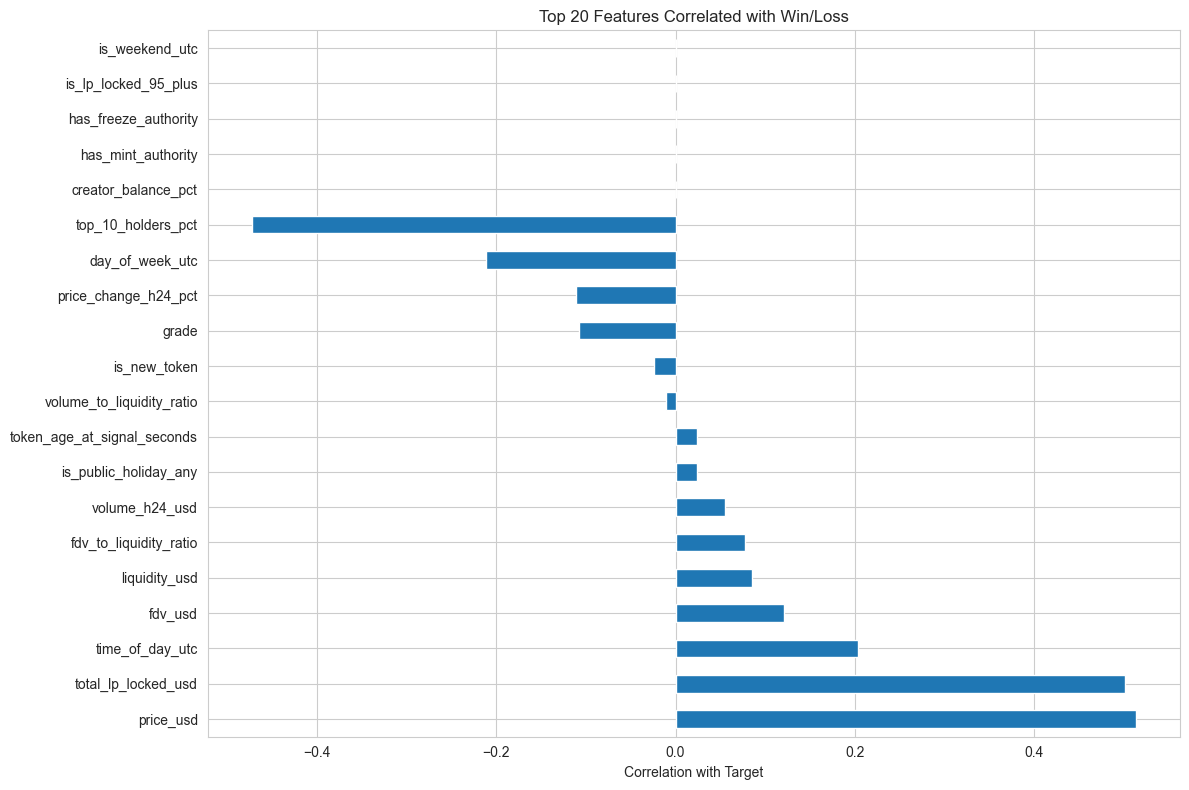


✅ Feature correlation analysis complete


In [22]:

# Feature Correlation with target
print("🔍 Top 15 Features Correlated with Target:")
print("-" * 60)

correlations = train_df[FEATURE_COLS + ['target']].corr()['target'].drop('target').sort_values(ascending=False)

for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
    print(f"{i:2}. {feature:40} | r = {corr:6.3f}")

# Plot
plt.figure(figsize=(12, 8))
correlations.head(20).plot(kind='barh')
plt.xlabel('Correlation with Target')
plt.title('Top 20 Features Correlated with Win/Loss')
plt.tight_layout()
plt.savefig('outputs/feature_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Feature correlation analysis complete")


In [ ]:

# Train XGBoost Model

# %%
print("🚀 Training XGBoost Model...")
print("-" * 60)

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Class imbalance ratio: {scale_pos_weight:.2f}")

# Initialize XGBoost
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    objective='binary:logistic',
    eval_metric='auc',
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,  
    random_state=42,
    early_stopping_rounds=20,
    n_jobs=-1
)


🚀 Training XGBoost Model...
------------------------------------------------------------
Class imbalance ratio: 1.25


In [24]:

# Train with validation set
eval_set = [(X_train, y_train), (X_test, y_test)]

model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True
)

print("\n✅ Model training complete!")

[0]	validation_0-auc:0.88700	validation_1-auc:0.81250
[1]	validation_0-auc:0.95600	validation_1-auc:0.81250
[2]	validation_0-auc:0.96000	validation_1-auc:0.76562
[3]	validation_0-auc:0.96600	validation_1-auc:0.76562
[4]	validation_0-auc:0.97500	validation_1-auc:0.68750
[5]	validation_0-auc:0.97200	validation_1-auc:0.68750
[6]	validation_0-auc:0.97200	validation_1-auc:0.68750
[7]	validation_0-auc:0.97400	validation_1-auc:0.68750
[8]	validation_0-auc:0.97600	validation_1-auc:0.65625
[9]	validation_0-auc:0.97500	validation_1-auc:0.65625
[10]	validation_0-auc:0.97700	validation_1-auc:0.68750
[11]	validation_0-auc:0.97500	validation_1-auc:0.68750
[12]	validation_0-auc:0.97700	validation_1-auc:0.68750
[13]	validation_0-auc:0.97700	validation_1-auc:0.68750
[14]	validation_0-auc:0.98700	validation_1-auc:0.68750
[15]	validation_0-auc:0.98900	validation_1-auc:0.68750
[16]	validation_0-auc:0.98300	validation_1-auc:0.68750
[17]	validation_0-auc:0.98100	validation_1-auc:0.68750
[18]	validation_0-au

In [25]:

# Cross-Validation

print("🔄 Running 5-Fold Time-Series Cross-Validation...")

# Use TimeSeriesSplit for proper time-series CV
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_fold_train = X_train.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Train
    fold_model = xgb.XGBClassifier(
        max_depth=6, learning_rate=0.1, n_estimators=200,
        scale_pos_weight=scale_pos_weight, random_state=42
    )
    fold_model.fit(X_fold_train, y_fold_train, verbose=False)
    
    # Evaluate
    score = roc_auc_score(y_fold_val, fold_model.predict_proba(X_fold_val)[:, 1])
    cv_scores.append(score)
    print(f"  Fold {fold}: AUC = {score:.4f}")

print(f"\n📊 Cross-Validation Results:")
print(f"  Mean AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

🔄 Running 5-Fold Time-Series Cross-Validation...
  Fold 1: AUC = 0.6000
  Fold 2: AUC = 0.5417
  Fold 3: AUC = nan
  Fold 4: AUC = 1.0000
  Fold 5: AUC = 1.0000

📊 Cross-Validation Results:
  Mean AUC: nan ± nan


In [26]:

# Model Evaluation

print("="*60)
print("📊 MODEL EVALUATION")
print("="*60)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# Accuracy
train_acc = (y_train_pred == y_train).mean()
test_acc = (y_test_pred == y_test).mean()

print(f"\n📈 Accuracy:")
print(f"  Training: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"  Test:     {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Gap:      {abs(train_acc - test_acc):.4f}")

# AUC
train_auc = roc_auc_score(y_train, y_train_proba)
test_auc = roc_auc_score(y_test, y_test_proba)

print(f"\n📈 ROC AUC:")
print(f"  Training: {train_auc:.4f}")
print(f"  Test:     {test_auc:.4f}")

📊 MODEL EVALUATION

📈 Accuracy:
  Training: 0.8667 (86.67%)
  Test:     0.7500 (75.00%)
  Gap:      0.1167

📈 ROC AUC:
  Training: 0.8870
  Test:     0.8125


In [27]:
# Confusion Matrix
print("\n" + "="*60)
print("📋 CONFUSION MATRIX")
print("="*60)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

print("\nTraining Set:")
print(cm_train)
print(f"  TN: {cm_train[0][0]}, FP: {cm_train[0][1]}")
print(f"  FN: {cm_train[1][0]}, TP: {cm_train[1][1]}")

print("\nTest Set:")
print(cm_test)
print(f"  TN: {cm_test[0][0]}, FP: {cm_test[0][1]}")
print(f"  FN: {cm_test[1][0]}, TP: {cm_test[1][1]}")


📋 CONFUSION MATRIX

Training Set:
[[22  3]
 [ 3 17]]
  TN: 22, FP: 3
  FN: 3, TP: 17

Test Set:
[[4 0]
 [3 5]]
  TN: 4, FP: 0
  FN: 3, TP: 5


In [28]:
# Classification Report
print("\n" + "="*60)
print("📊 CLASSIFICATION REPORT")
print("="*60)

print("\nTest Set:")
print(classification_report(
    y_test, y_test_pred,
    target_names=['Loss', 'Win'],
    digits=4
))


📊 CLASSIFICATION REPORT

Test Set:
              precision    recall  f1-score   support

        Loss     0.5714    1.0000    0.7273         4
         Win     1.0000    0.6250    0.7692         8

    accuracy                         0.7500        12
   macro avg     0.7857    0.8125    0.7483        12
weighted avg     0.8571    0.7500    0.7552        12




📈 Plotting ROC Curve...


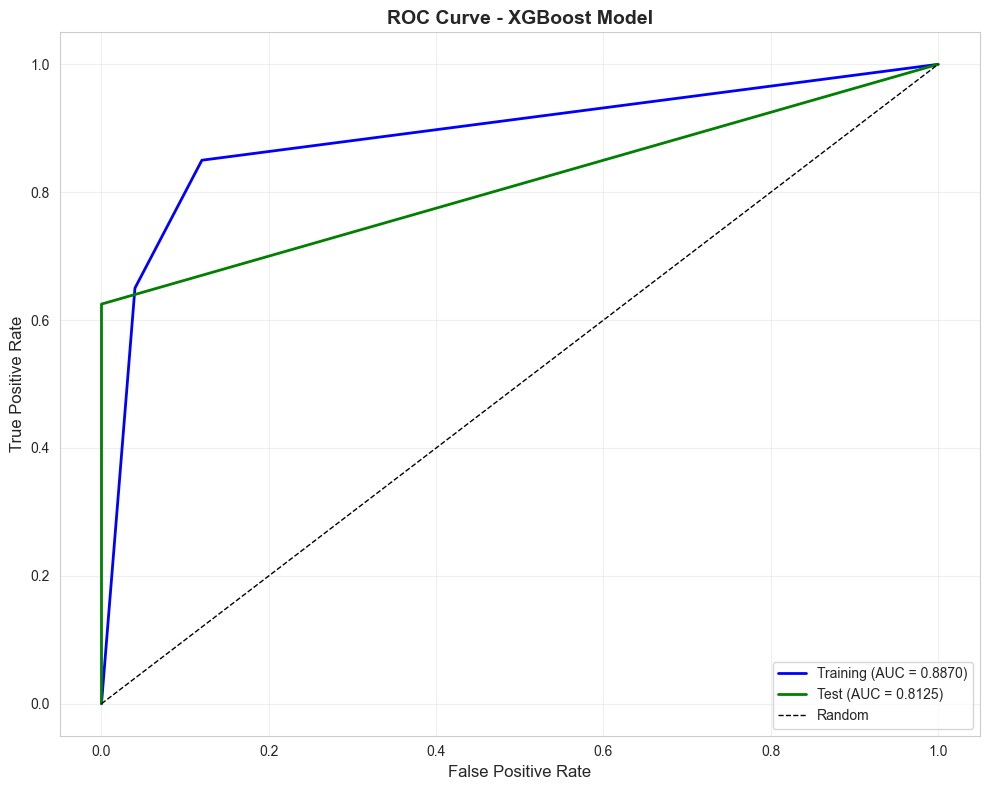

In [29]:
# ROC Curve
print("\n📈 Plotting ROC Curve...")

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, linewidth=2, 
         label=f'Training (AUC = {train_auc:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, linewidth=2,
         label=f'Test (AUC = {test_auc:.4f})', color='green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoost Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


📈 Plotting Precision-Recall Curve...


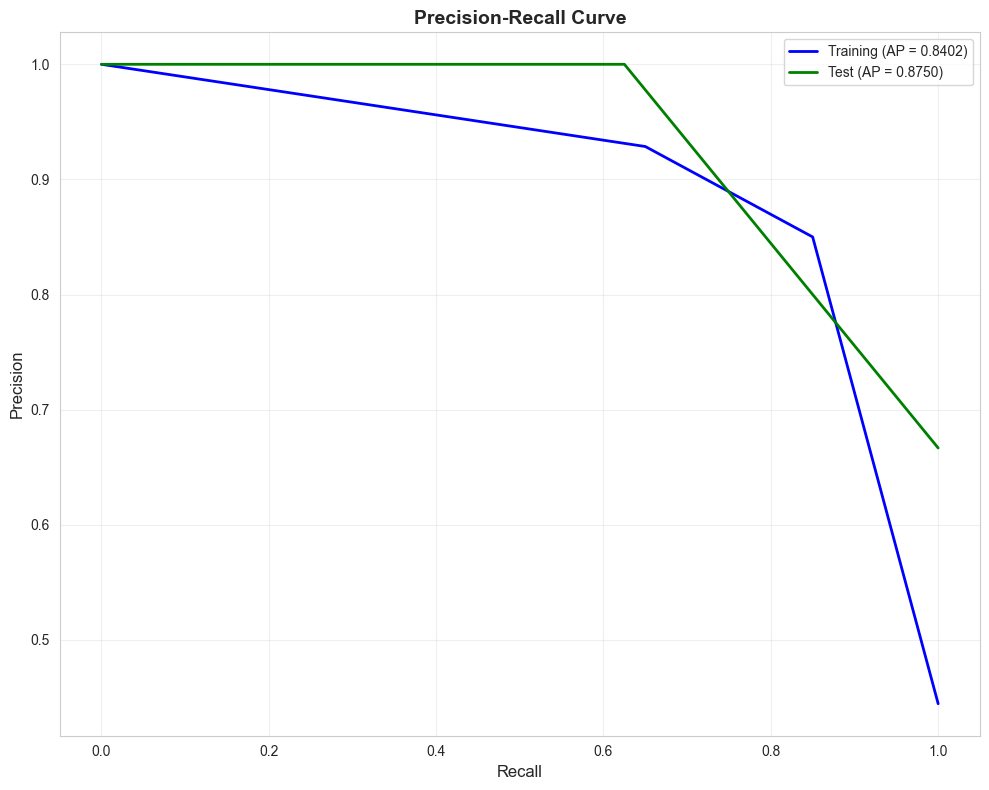


✅ Average Precision:
  Training: 0.8402
  Test:     0.8750


In [30]:
# Precision-Recall Curve
print("\n📈 Plotting Precision-Recall Curve...")

precision_train, recall_train, _ = precision_recall_curve(y_train, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_test_proba)

ap_train = average_precision_score(y_train, y_train_proba)
ap_test = average_precision_score(y_test, y_test_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall_train, precision_train, linewidth=2,
         label=f'Training (AP = {ap_train:.4f})', color='blue')
plt.plot(recall_test, precision_test, linewidth=2,
         label=f'Test (AP = {ap_test:.4f})', color='green')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('outputs/precision_recall_curve.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Average Precision:")
print(f"  Training: {ap_train:.4f}")
print(f"  Test:     {ap_test:.4f}")

In [31]:

# Feature Importance

print("="*60)
print("🔍 FEATURE IMPORTANCE")
print("="*60)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': FEATURE_COLS,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print("-" * 60)
for i, row in feature_importance.head(20).iterrows():
    print(f"{row['feature']:40} | {row['importance']:.4f}")

🔍 FEATURE IMPORTANCE

Top 20 Most Important Features:
------------------------------------------------------------
top_10_holders_pct                       | 0.4501
day_of_week_utc                          | 0.1814
total_lp_locked_usd                      | 0.1627
grade                                    | 0.0844
price_usd                                | 0.0662
time_of_day_utc                          | 0.0551
volume_h24_usd                           | 0.0000
liquidity_usd                            | 0.0000
fdv_usd                                  | 0.0000
price_change_h24_pct                     | 0.0000
has_mint_authority                       | 0.0000
is_lp_locked_95_plus                     | 0.0000
creator_balance_pct                      | 0.0000
has_freeze_authority                     | 0.0000
is_weekend_utc                           | 0.0000
is_public_holiday_any                    | 0.0000
signal_source                            | 0.0000
token_age_at_signal_seconds        

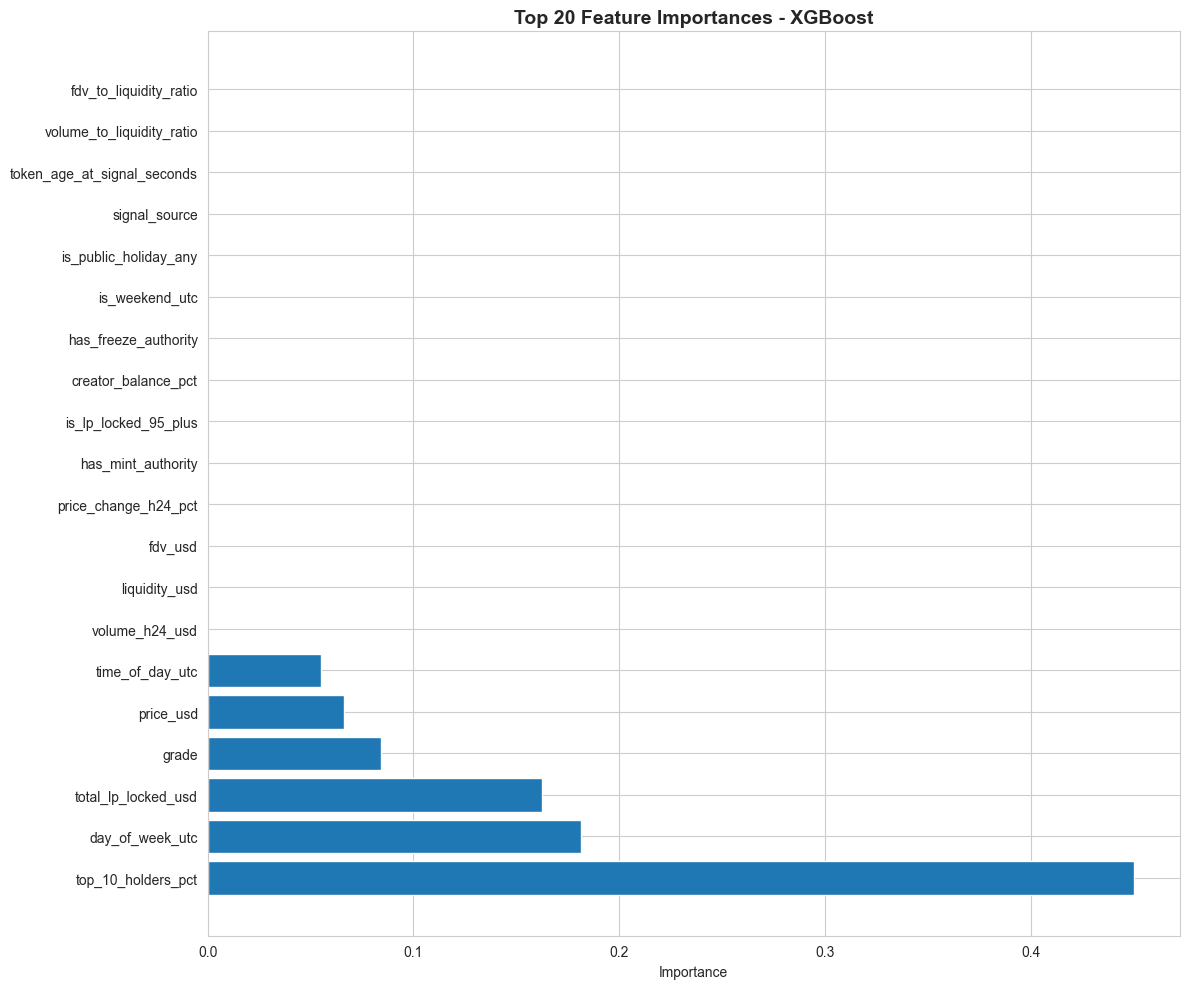

In [32]:
# Plot feature importance
plt.figure(figsize=(12, 10))
top_features = feature_importance.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

In [33]:

# Prediction Analysis

print("="*60)
print("🔍 PREDICTION ANALYSIS")
print("="*60)

# Analyze predictions by confidence
test_df_pred = test_df.copy()
test_df_pred['predicted_proba'] = y_test_proba
test_df_pred['predicted_class'] = y_test_pred
test_df_pred['correct'] = (y_test_pred == y_test).astype(int)

# Group by confidence bins
bins = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
test_df_pred['confidence_bin'] = pd.cut(test_df_pred['predicted_proba'], bins=bins)

print("\n📊 Performance by Confidence Level:")
print("-" * 60)
conf_analysis = test_df_pred.groupby('confidence_bin').agg({
    'correct': ['count', 'sum', 'mean'],
    'target': 'mean'
})
print(conf_analysis)

🔍 PREDICTION ANALYSIS

📊 Performance by Confidence Level:
------------------------------------------------------------
               correct                  target
                 count sum      mean      mean
confidence_bin                                
(0.0, 0.5]           7   4  0.571429  0.428571
(0.5, 0.6]           5   5  1.000000  1.000000
(0.6, 0.7]           0   0       NaN       NaN
(0.7, 0.8]           0   0       NaN       NaN
(0.8, 0.9]           0   0       NaN       NaN
(0.9, 1.0]           0   0       NaN       NaN


In [34]:

# High confidence predictions
high_conf = test_df_pred[test_df_pred['predicted_proba'] >= 0.7]
print(f"\n🎯 High Confidence Predictions (>=0.7):")
print(f"  Count: {len(high_conf)}")
print(f"  Accuracy: {high_conf['correct'].mean():.4f}")
print(f"  Win rate: {high_conf['target'].mean():.4f}")


🎯 High Confidence Predictions (>=0.7):
  Count: 0
  Accuracy: nan
  Win rate: nan


In [35]:

# Misclassifications
misclassified = test_df_pred[test_df_pred['correct'] == 0]
print(f"\n❌ Misclassified Samples: {len(misclassified)}")

if len(misclassified) > 0:
    print("\nMisclassification Analysis:")
    print(f"  False Positives (predicted win, actual loss): {((misclassified['predicted_class'] == 1) & (misclassified['target'] == 0)).sum()}")
    print(f"  False Negatives (predicted loss, actual win): {((misclassified['predicted_class'] == 0) & (misclassified['target'] == 1)).sum()}")


❌ Misclassified Samples: 3

Misclassification Analysis:
  False Positives (predicted win, actual loss): 0
  False Negatives (predicted loss, actual win): 3


In [36]:

# Save Model for Production

print("="*60)
print("💾 SAVING MODEL FOR PRODUCTION")
print("="*60)

import os
os.makedirs('models', exist_ok=True)

# Save model
model_path = 'models/xgboost_signal_classifier.pkl'
joblib.dump(model, model_path)
print(f"✅ Model saved: {model_path}")

# Save label encoders
encoders_path = 'models/label_encoders.pkl'
joblib.dump(label_encoders, encoders_path)
print(f"✅ Label encoders saved: {encoders_path}")

# Save feature names
features_path = 'models/feature_names.json'
with open(features_path, 'w') as f:
    json.dump(FEATURE_COLS, f, indent=2)
print(f"✅ Feature names saved: {features_path}")

# Save metadata
metadata = {
    'model_type': 'XGBClassifier',
    'trained_at': datetime.now().isoformat(),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'features': FEATURE_COLS,
    'performance': {
        'train_accuracy': float(train_acc),
        'test_accuracy': float(test_acc),
        'train_auc': float(train_auc),
        'test_auc': float(test_auc),
        'cv_auc_mean': float(np.mean(cv_scores)),
        'cv_auc_std': float(np.std(cv_scores))
    },
    'hyperparameters': {
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 200,
        'scale_pos_weight': float(scale_pos_weight)
    }
}

metadata_path = 'models/model_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadata saved: {metadata_path}")

print("\n" + "="*60)
print("✅ MODEL READY FOR PRODUCTION DEPLOYMENT!")
print("="*60)

💾 SAVING MODEL FOR PRODUCTION
✅ Model saved: models/xgboost_signal_classifier.pkl
✅ Label encoders saved: models/label_encoders.pkl
✅ Feature names saved: models/feature_names.json
✅ Metadata saved: models/model_metadata.json

✅ MODEL READY FOR PRODUCTION DEPLOYMENT!


In [37]:

# Production Integration Code

print("""
To integrate this model into your collector.py:

1. Copy the MLSignalFilter class from the integration guide
2. Set in your .env:
   ML_MODEL_PATH=models/xgboost_signal_classifier.pkl
   ML_MIN_CONFIDENCE=0.7

3. The filter will automatically:
   - Load the model
   - Extract features from snapshots
   - Predict win probability
   - Reject low-confidence signals

4. Monitor performance:
   - Track ML-approved vs rejected signals
   - Compare win rates
   - Retrain weekly with new data
""")


To integrate this model into your collector.py:

1. Copy the MLSignalFilter class from the integration guide
2. Set in your .env:
   ML_MODEL_PATH=models/xgboost_signal_classifier.pkl
   ML_MIN_CONFIDENCE=0.7

3. The filter will automatically:
   - Load the model
   - Extract features from snapshots
   - Predict win probability
   - Reject low-confidence signals

4. Monitor performance:
   - Track ML-approved vs rejected signals
   - Compare win rates
   - Retrain weekly with new data



In [38]:
# Final Summary

print("\n" + "="*80)
print("🎉 MODEL TRAINING COMPLETE - SUMMARY")
print("="*80)

print(f"\n📊 Dataset:")
print(f"  Total samples: {len(df)}")
print(f"  Training: {len(X_train)}")
print(f"  Test: {len(X_test)}")
print(f"  Features: {len(FEATURE_COLS)}")

print(f"\n🎯 Performance:")
print(f"  Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  Test AUC: {test_auc:.4f}")
print(f"  CV AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

print(f"\n✅ Model Status:")
if test_auc >= 0.70:
    print(f"  🟢 EXCELLENT - Ready for production!")
elif test_auc >= 0.65:
    print(f"  🟡 GOOD - Deploy with monitoring")
else:
    print(f"  🔴 NEEDS IMPROVEMENT - Collect more data")

print(f"\n📁 Saved Files:")
print(f"  - {model_path}")
print(f"  - {encoders_path}")
print(f"  - {features_path}")
print(f"  - {metadata_path}")

print("\n" + "="*80)


🎉 MODEL TRAINING COMPLETE - SUMMARY

📊 Dataset:
  Total samples: 57
  Training: 45
  Test: 12
  Features: 21

🎯 Performance:
  Test Accuracy: 0.7500 (75.00%)
  Test AUC: 0.8125
  CV AUC: nan ± nan

✅ Model Status:
  🟢 EXCELLENT - Ready for production!

📁 Saved Files:
  - models/xgboost_signal_classifier.pkl
  - models/label_encoders.pkl
  - models/feature_names.json
  - models/model_metadata.json

